In [1]:
import scipy as sp
import scipy.io
from scipy import stats
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import csv
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as plt
import matplotlib.patches as patch
from matplotlib import gridspec
from datetime import datetime

In [2]:
projects_df = pd.read_csv('Projects.csv')
donations_df = pd.read_csv('Donations.csv')
schools_df = pd.read_csv('Schools.csv')

In [3]:
display(projects_df.head(3))
display(donations_df.head(3))
schools_df.head(3)

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Short Description,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,Teacher-Led,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Did you know that 1-7 students in grades K-12 ...,"My students need 25 copies of ""Bullying in Sch...",Applied Learning,"Character Education, Early Development",Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,Fully Funded,2013-01-11
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,Teacher-Led,Learning in Color!,"Help us have a fun, interactive listening cent...","Help us have a fun, interactive listening cent...","My students need a listening center, read alon...","Applied Learning, Literacy & Language","Early Development, Literacy",Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,Expired,NaN
2,afd99a01739ad5557b51b1ba0174e832,1287f5128b1f36bf8434e5705a7cc04d,6c5bd0d4f20547a001628aefd71de89e,1,Teacher-Led,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Visiting or moving to a new place can be very ...,My students need beginning vocabulary audio ca...,Literacy & Language,ESL,Grades PreK-2,Supplies,435.92,2013-01-01,2013-05-30,Fully Funded,2013-05-22


,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46


,School ID,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
0,00003e0fdd601b8ea0a6eb44057b9c5e,Capon Bridge Middle School,rural,56.0,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District
1,00004e32a448b4832e1b993500bf0731,The Woodlands College Park High School,urban,41.0,Texas,77384,The Woodlands,Montgomery,Conroe Ind School District
2,0002021bb799f28de224f1acc1ff08c4,Samantha Smith Elementary School,suburban,2.0,Washington,98074,Sammamish,King,Lake Washington Sch Dist 414


In [4]:
proj_df = projects_df.copy().dropna(subset = ['Project Fully Funded Date'])

In [5]:
proj_df['Project Fully Funded Date'] = pd.to_datetime(proj_df['Project Fully Funded Date'])
donations_df['Donation Received Date'] = pd.to_datetime(donations_df['Donation Received Date'])

In [6]:
proj_grouped = proj_df.groupby(pd.Grouper(key = 'Project Fully Funded Date', freq = 'W'))
don_grouped = donations_df.groupby(pd.Grouper(key = 'Donation Received Date', freq = 'W'))

In [7]:
weekly_funded = proj_grouped.size()

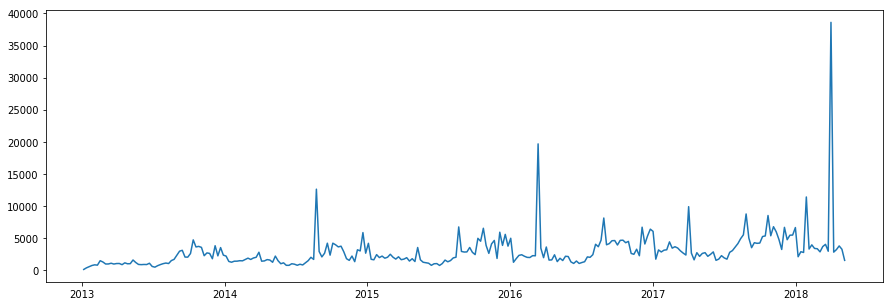

In [43]:
fig,ax = plt.subplots()
fig.set_size_inches(15,5)
ax.plot(weekly_funded)

In [44]:
weekly_funded.sort_values().index[-1]

Timestamp('2018-04-01 00:00:00')

In [19]:
biggest_gr = proj_grouped.get_group(weekly_funded.sort_values().index[-1])
sec_biggest_gr = proj_grouped.get_group(weekly_funded.sort_values().index[-2])

str(biggest_gr['Project Fully Funded Date'].min().date()) + ' - ' + str(biggest_gr['Project Fully Funded Date'].max().date())

'2018-03-26 - 2018-04-01'

https://www.donorschoose.org/blog/best-school-day-2018/

In [46]:
sec_biggest_gr = proj_grouped.get_group(weekly_funded.sort_values().index[-2])
sec_biggest_gr['Project Fully Funded Date'].value_counts()

2016-03-09    12272
2016-03-10     3234
2016-03-11     2171
2016-03-12      809
2016-03-13      577
2016-03-08      312
2016-03-07      305
Name: Project Fully Funded Date, dtype: int64

https://www.donorschoose.org/blog/best-school-day-recap/

# Average donation size by state

In [47]:
projects_df['Project Current Status'].value_counts()

Fully Funded    821367
Expired         241329
Archived         98003
Live             47952
Name: Project Current Status, dtype: int64

In [48]:
projects_df.shape

(1208651, 15)

In [49]:
schools_df.shape

(72993, 9)

In [50]:
donations_df.shape

(4687884, 7)

#### Merge dataframes to collect 'School State' and 'Donation Amount' into one dataframe

In [51]:
proj_school_df = schools_df[['School ID', 'School State']].merge(projects_df[['School ID','Project ID']], how = 'outer', on = ['School ID'])
don_proj_school_df = proj_school_df.merge(donations_df, how = 'outer', on = ['Project ID'])
don_proj_school_df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4994571 entries, 0 to 4994570
Data columns (total 9 columns):
School ID                              4994571 non-null object
School State                           4994571 non-null object
Project ID                             4994571 non-null object
Donation ID                            4687887 non-null object
Donor ID                               4687887 non-null object
Donation Included Optional Donation    4687887 non-null object
Donation Amount                        4687887 non-null float64
Donor Cart Sequence                    4687887 non-null float64
Donation Received Date                 4687887 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 381.1+ MB


In [52]:
state_grps = don_proj_school_df.groupby(['School State'])

In [53]:
donations_by_state = state_grps['Donation Amount'].describe()

In [54]:
donations_by_state.index.rename('State', inplace = True)
donations_by_state = donations_by_state.reset_index()
donations_by_state.head()

,State,count,mean,std,min,25%,50%,75%,max
0,Alabama,57749.0,60.823039,168.744893,0.52,10.0000,25.0,50.000,9997.47
1,Alaska,13614.0,66.688168,166.294934,1.00,19.4475,30.0,60.000,9989.41
2,Arizona,91036.0,60.724443,175.995691,0.02,20.0000,25.0,50.000,14198.66
3,Arkansas,33889.0,53.368843,151.949886,0.77,10.0000,25.0,50.000,10081.59
4,California,697415.0,65.397360,176.278658,0.01,15.0000,25.0,54.685,25000.00


In [58]:
states = gpd.read_file(r'us-states.json')
states = states.merge(donations_by_state, left_on ='name', right_on = 'State')
states['scaled_mean_donations'] = states['mean']/states['density']
states[['scaled_mean_donations(log)', 'mean(log)', 'density(log)']] = states[['scaled_mean_donations', 'mean', 'density']].apply(np.log)

states.head(2)

,id,name,density,geometry,State,count,mean,std,min,25%,50%,75%,max,scaled_mean_donations,scaled_mean_donations(log),mean(log),density(log)
0,01,Alabama,94.650,"POLYGON ((-87.359296 35.00118, -85.606675 34.9...",Alabama,57749.0,60.823039,168.744893,0.52,10.0000,25.0,50.0,9997.47,0.642610,-0.442217,4.107969,4.550186
1,02,Alaska,1.264,"(POLYGON ((-131.602021 55.117982, -131.569159 ...",Alaska,13614.0,66.688168,166.294934,1.00,19.4475,30.0,60.0,9989.41,52.759627,3.965746,4.200028,0.234281


In [59]:
states.loc[states['name'] == 'Alaska', 'geometry'] = states.loc[states['name'] == 'Alaska', 'geometry'].scale(0.6,0.6,0.6).translate(25)
states.loc[states['name'] == 'Hawaii', 'geometry'] = states.loc[states['name'] == 'Hawaii', 'geometry'].scale(1.6,1.6,1.6).translate(25, 10)

In [223]:
def clean_subplot(ax, title = None, ylabel = None):
    ax.set_title(title, fontsize = 14)
    ax.set_ylabel(ylabel)
    ax.yaxis.set_label_position("right")
    ax.axes.get_xaxis().set_visible(False)
    plt.box(on = None)
    ax.set_yticks([])
    ax.yaxis.labelpad = 80

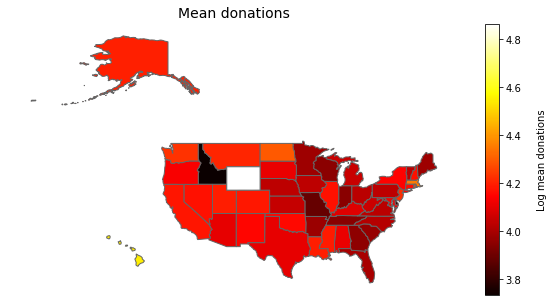

In [224]:
figure, ax1 = plt.subplots(1,1, figsize = (10,5))
states.plot(column = 'mean(log)', cmap = 'hot', ax = ax1, legend = True, linewidth = 1, edgecolor = [0.4,0.4,0.4])
clean_subplot(ax1, 'Mean donations', 'Log mean donations')

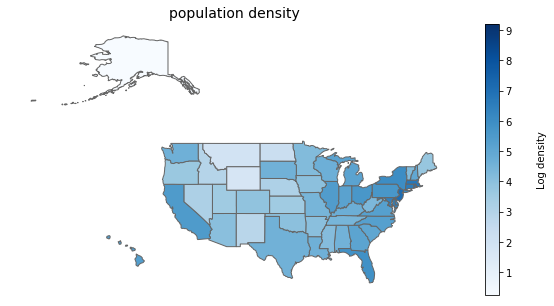

In [225]:
figure, ax1 = plt.subplots(1,1, figsize = (10,5))
states.plot(column = 'density(log)', cmap = 'Blues', ax = ax1, legend = True, linewidth = 1, edgecolor = [0.4,0.4,0.4])
clean_subplot(ax1, 'population density', 'Log density')

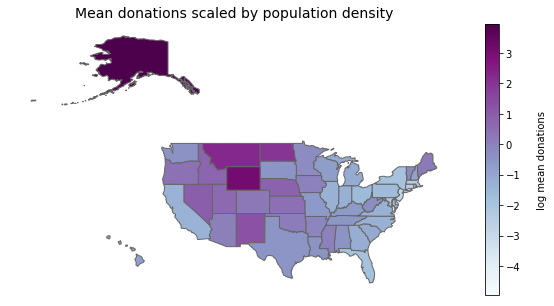

In [230]:
figure, ax1 = plt.subplots(1,1, figsize = (10,5))
states.plot(column = 'scaled_mean_donations(log)', cmap = 'BuPu', ax = ax1, legend = True, linewidth = 1, edgecolor = [0.4,0.4,0.4])
clean_subplot(ax1, 'Mean donations scaled by population density', 'log mean donations')

In [63]:
states['centroid'] = states['geometry'].centroid
states['centroid_lon'] = states['centroid'].apply(lambda c: -1*c.x)
states['centroid_lat'] = states['centroid'].apply(lambda c: c.y)

C:\Users\efink\Anaconda3\envs\kaggle\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


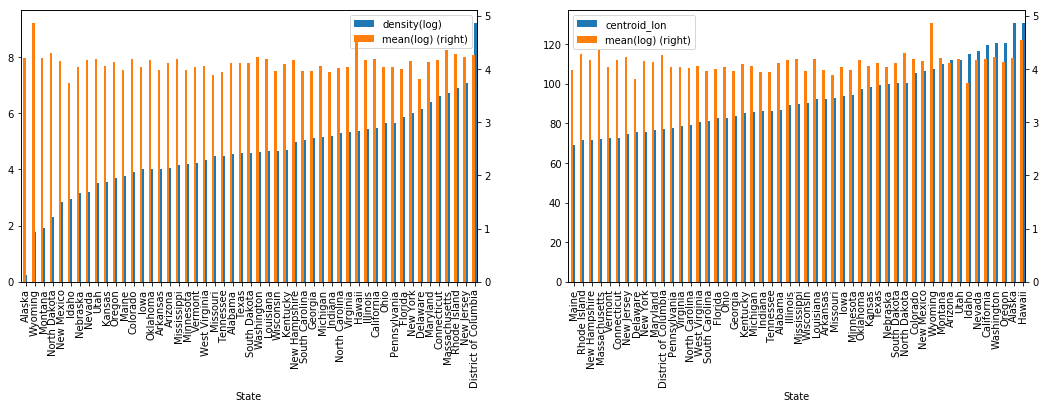

In [64]:
figure, (ax1,ax2) = plt.subplots(1,2, figsize = (18,5))
states_by_density = pd.DataFrame(states.sort_values('density'))
states_by_density.plot(x = 'State', y = ['density(log)'], kind = 'bar', ax = ax1, width = .3)
states_by_density.plot(x = 'State', y = ['mean(log)'], kind = 'bar', ax = ax1, secondary_y = True, position = 1.2, 
                        width = .3, color = 'C1')
states_by_lon = pd.DataFrame(states.sort_values('centroid_lon'))
states_by_lon.plot(x = 'State', y = ['centroid_lon'], kind = 'bar', ax = ax2, width = .3)
states_by_lon.plot(x = 'State', y = ['mean(log)'], kind = 'bar', ax = ax2, secondary_y = True, color = 'C1', position = 1.2, width = .3)

## Conclusions:
* Mean donation amount does not correlate with population density or longitude of state
* Mean donation amount is fairly evenly spread out among states
* Wyoming has the highest mean donation rate despite having one of the lowest population densities

# Total donations by state

In [83]:
states['Total_donations_amount'] = states['count'] * states['mean']

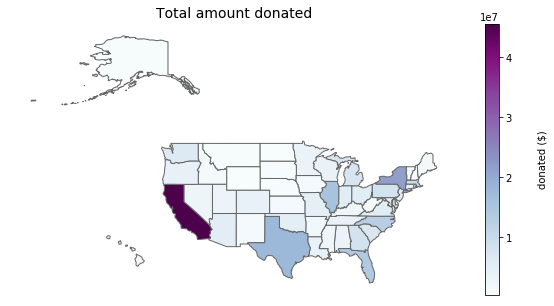

In [226]:
figure, ax1 = plt.subplots(1,1, figsize = (10,5))
states.plot(column = 'Total_donations_amount', cmap = 'BuPu', ax = ax1, legend = True, linewidth = 1, edgecolor = [0.4,0.4,0.4])
clean_subplot(ax1, 'Total amount donated', 'donated ($)')

In [85]:
states['Total_donations_amount_scaled_by_density'] = states['Total_donations_amount']/states['density']
states['Total_donations_amount_scaled_by_density'] = np.log(states['Total_donations_amount_scaled_by_density'])

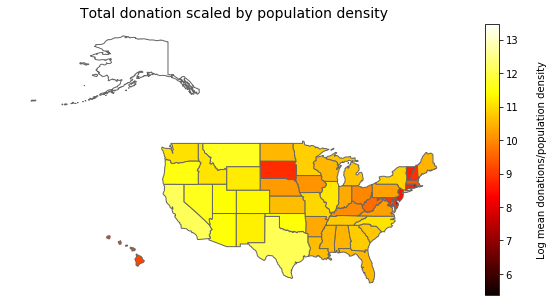

In [232]:
figure, ax1 = plt.subplots(1,1, figsize = (10,5))
states.plot(column = 'Total_donations_amount_scaled_by_density', cmap = 'hot', ax = ax1, legend = True, linewidth = 1, edgecolor = [0.4,0.4,0.4])
clean_subplot(ax1, 'Total donation scaled by population density', 'Log mean donations/population density')

In [90]:
gdp_by_state = pd.read_csv('GDP_state.csv', skiprows= [0,1,3], header = [1])

In [91]:
gdp_by_state = gdp_by_state.drop('Fips', axis = 1).rename(columns = {'Area': 'State'})
gdp_by_state['annual_gdp'] = gdp_by_state.iloc[:,1:].mean(axis = 1)
states = states.merge(gdp_by_state[['State', 'annual_gdp']], on = 'State')
states['Total_donations_scaled_by_GDP'] = states['Total_donations_amount']/states['annual_gdp']


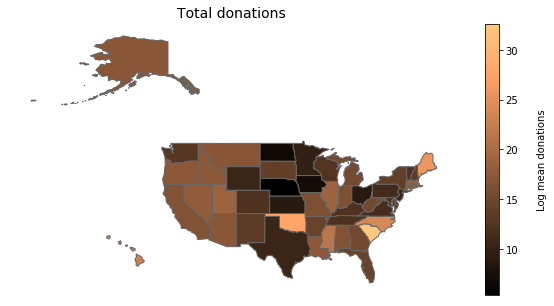

In [233]:
figure, ax1 = plt.subplots(1,1, figsize = (10,5))

states.plot(column = 'Total_donations_scaled_by_GDP', cmap = 'copper', ax = ax1, legend = True, linewidth = 1, edgecolor = [0.4,0.4,0.4])
ax1.set_title('Total amount raised scaled by annual GDP', fontsize = 14)
clean_subplot(ax1, 'Total donations ', 'Log mean donations')

In [161]:
states_sorted_by_density = pd.DataFrame(states.sort_values(by = 'density'))
states_sorted_by_GDP = pd.DataFrame(states.sort_values(by = 'annual_gdp'))

C:\Users\efink\Anaconda3\envs\kaggle\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


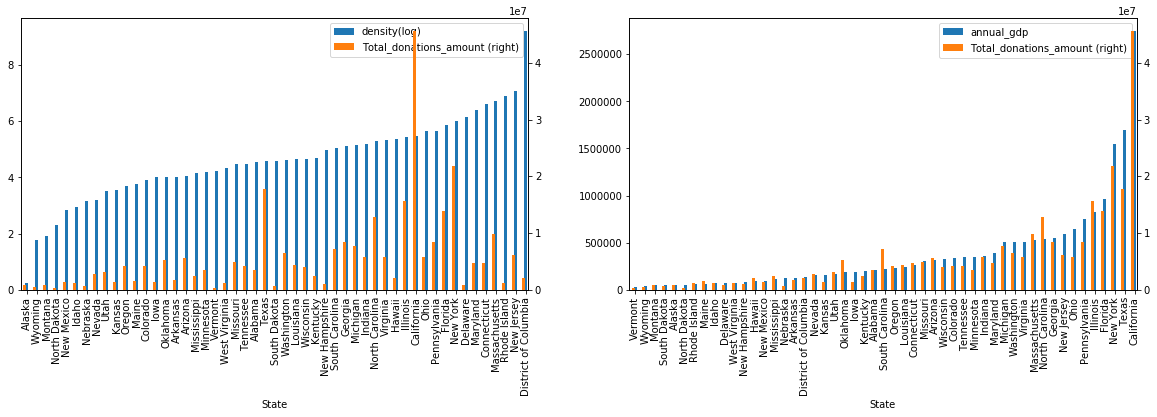

In [166]:
figure, (ax1,ax2) = plt.subplots(1,2, figsize = (20,5))

states_sorted_by_density.plot(x = 'State', y = ['density(log)'], kind = 'bar', ax = ax1, width = .3,)
states_sorted_by_density.plot(x = 'State', y = ['Total_donations_amount'], kind = 'bar', ax = ax1, secondary_y = True, color = 'C1', position = 1.2, width = .3)

states_sorted_by_GDP.plot(x = 'State', y = ['annual_gdp'], kind = 'bar', ax = ax2, width = .3,)
states_sorted_by_GDP.plot(x = 'State', y = ['Total_donations_amount'], kind = 'bar', ax = ax2, secondary_y = True, color = 'C1', position = 1.2, width = .3)


In [ ]:
figure, (ax1,ax2) = plt.subplots(1,2, figsize = (20,5))

states_sorted_by_density.plot(x = 'State', y = ['density(log)'], kind = 'bar', ax = ax1, width = .3,)

## Conclusions:
* 